In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device : ', device)

device :  cuda:0


In [3]:
# 0~1, -1~1
transform = transforms.Compose([
    # 0 ~ 1
    transforms.ToTensor(),
    # (0 - 0.5) / 0.5 --> -1 /  (1 -0.5)/0.5 --> 1 # -1~1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # (mean), (std) for each channel --> (data - mean) / std
    # flip 좌우반전
    transforms.RandomHorizontalFlip(p=0.5),
])

# 0~1, -1~1
transform_test = transforms.Compose([
    # 0 ~ 1
    transforms.ToTensor(),
    # (0 - 0.5) / 0.5 --> -1 /  (1 -0.5)/0.5 --> 1 # -1~1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # (mean), (std) for each channel --> (data - mean) / std
])

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:13<00:00, 13080959.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [14]:
class simple_cnn(nn.Module):
  def __init__(self):
    #32/32/3
    super(simple_cnn, self).__init__()

    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3,3) ),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(3,3) ),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2 ),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3)),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # 5*5*16
    )
    # fc layer Linear

    self.fc_layer = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(16*5*5, 64),
        nn.ReLU(inplace=True),
        nn.Linear(64, 32),
        nn.ReLU(inplace=True),
        nn.Linear(32, 10),
    )

  def forward(self, x):
    o = self.conv_layer(x)
    # 5x5x16 # batch size- channel, h, w
    o = o.view(o.shape[0], -1) #numpy reshape
    o = self.fc_layer(o)

    return o


In [15]:
cnn_net = simple_cnn()

In [16]:
from torchsummary import summary

In [17]:
cnn_net = cnn_net.to(device)

In [18]:
summary(cnn_net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 30, 30]             112
              ReLU-2            [-1, 4, 30, 30]               0
            Conv2d-3           [-1, 16, 28, 28]             592
              ReLU-4           [-1, 16, 28, 28]               0
         MaxPool2d-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 16, 12, 12]           2,320
              ReLU-7           [-1, 16, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           2,320
              ReLU-9           [-1, 16, 10, 10]               0
        MaxPool2d-10             [-1, 16, 5, 5]               0
          Dropout-11                  [-1, 400]               0
           Linear-12                   [-1, 64]          25,664
             ReLU-13                   [-1, 64]               0
           Linear-14                   

In [19]:
criterion = nn.CrossEntropyLoss() #
optimizer = optim.Adam(cnn_net.parameters(), lr=0.001)

In [30]:
epochs = 10

In [31]:
for e in range(epochs):
  for it_bat, (img, lab) in enumerate(trainloader):
    img = img.to(device)
    lab = lab.to(device)

    optimizer.zero_grad()
    outputs = cnn_net(img)

    loss = criterion(outputs, lab)
    loss.backward()

    optimizer.step()

    if (it_bat+1) % 50 == 0:
      print(f'epoch{e}, batch{it_bat+1}, loss{loss.item()}')


epoch0, batch50, loss1.6195068359375
epoch0, batch100, loss1.426978588104248
epoch0, batch150, loss1.6716639995574951
epoch0, batch200, loss1.6845839023590088
epoch0, batch250, loss1.602087378501892
epoch0, batch300, loss1.3773547410964966
epoch0, batch350, loss1.4515858888626099
epoch0, batch400, loss1.5843719244003296
epoch0, batch450, loss1.400844693183899
epoch0, batch500, loss1.2587789297103882
epoch1, batch50, loss1.5204678773880005
epoch1, batch100, loss1.3050390481948853
epoch1, batch150, loss1.3163235187530518
epoch1, batch200, loss1.3678371906280518
epoch1, batch250, loss1.2044368982315063
epoch1, batch300, loss1.344252586364746
epoch1, batch350, loss1.4091484546661377
epoch1, batch400, loss1.5359725952148438
epoch1, batch450, loss1.2834348678588867
epoch1, batch500, loss1.4283050298690796
epoch2, batch50, loss1.5537604093551636
epoch2, batch100, loss1.4070172309875488
epoch2, batch150, loss1.3861420154571533
epoch2, batch200, loss1.2649844884872437
epoch2, batch250, loss1.42

In [65]:
with torch.no_grad():
  cnn_net.eval()
  total_cnt =0
  correct_cnt=0
  for it_batch, (img, lab) in enumerate(testloader):
      img = img.to(device)
      lab = lab.to(device)

      total_cnt += img.shape[0]
      outputs = cnn_net(img)

      pred = torch.argmax(outputs, axis=1)
      correct_cnt +=(pred == lab).sum().item()


In [66]:
print(f'correct{correct_cnt}, total{total_cnt}, acc{correct_cnt/total_cnt*100}')

correct6207, total10000, acc62.07


In [67]:
sample = next(iter(testloader))
o = cnn_net(sample[0].to(device))
pred = torch.argmax(o, axis=1).to('cpu')
correct = pred == sample[1]
correct.sum().item()

68

In [60]:
import matplotlib.pyplot as plt

In [68]:
def display_sample(img, gt, pred):
  img = img.numpy()
  img = img.transpose(1, 2, 0)
  img = img * 0.5 + 0.5

  plt.figure(figsize=(3,3))
  title_ = 'gt[%s],pred[%s]' % (classes[gt.item()], classes[pred.item()])
  plt.title(title_)
  plt.imshow(img)
  plt.show()

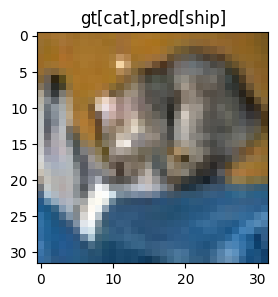

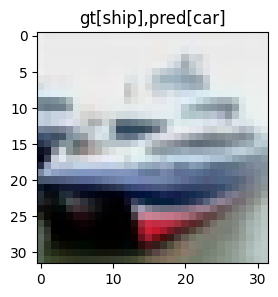

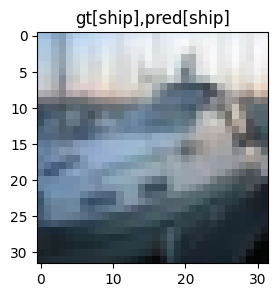

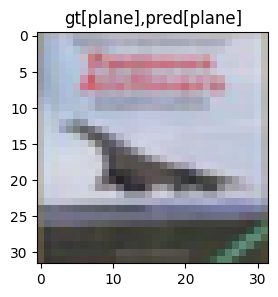

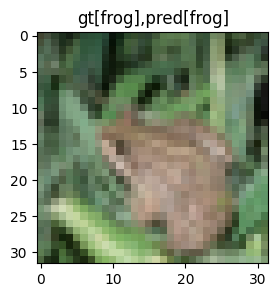

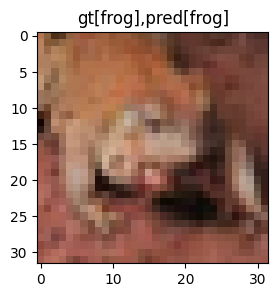

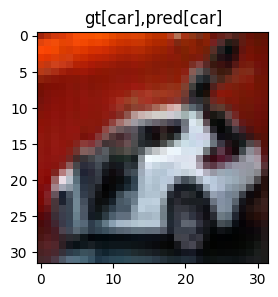

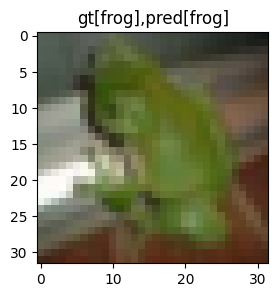

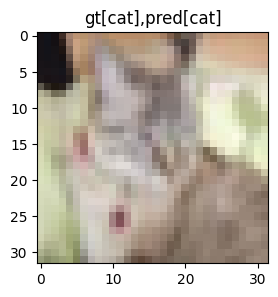

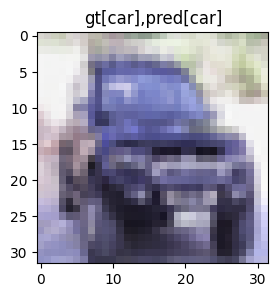

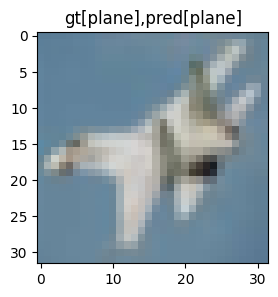

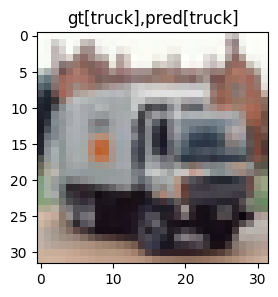

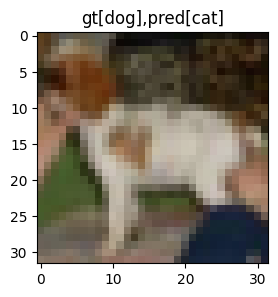

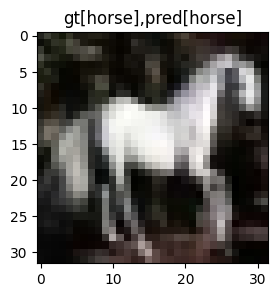

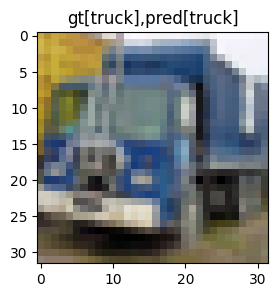

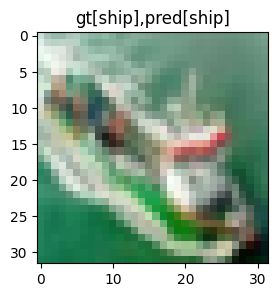

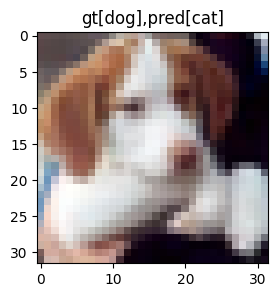

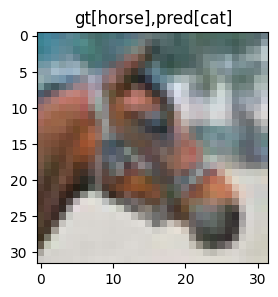

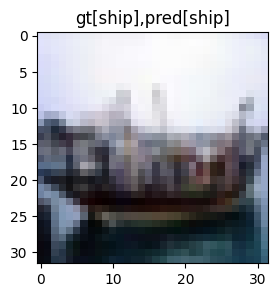

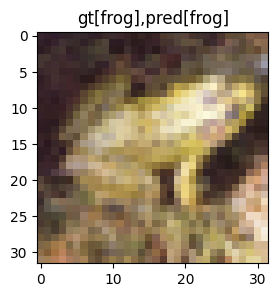

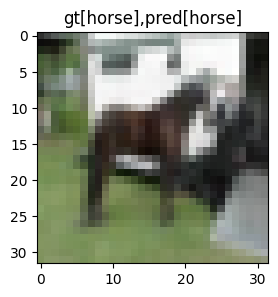

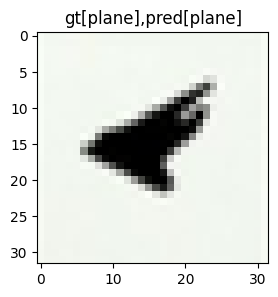

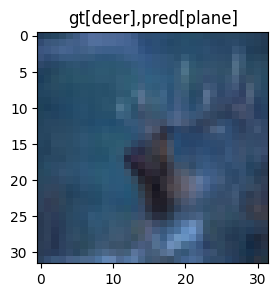

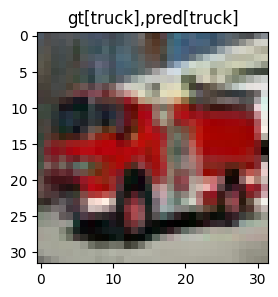

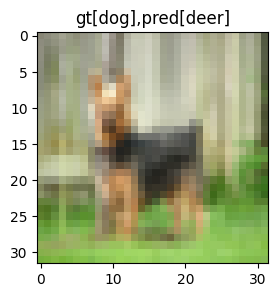

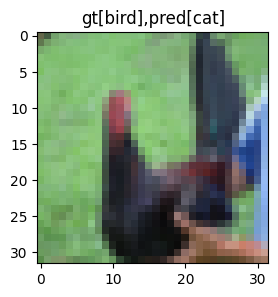

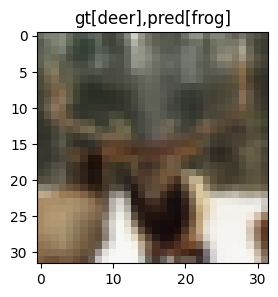

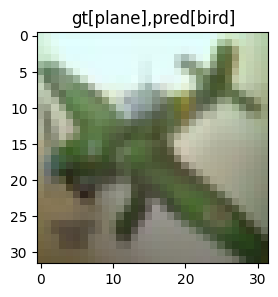

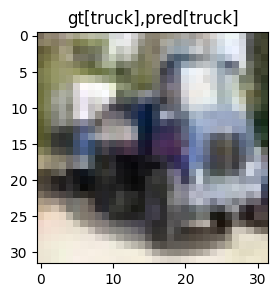

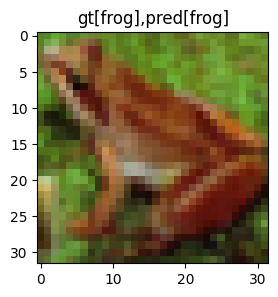

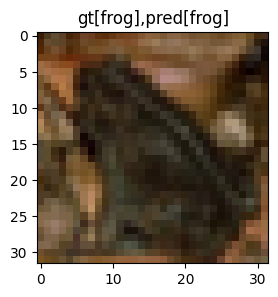

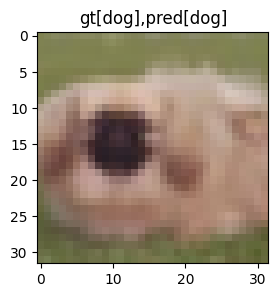

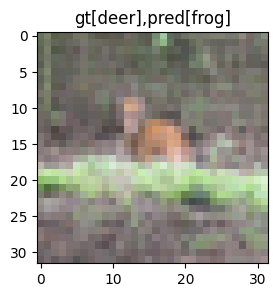

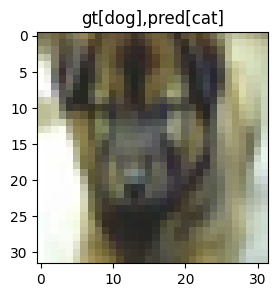

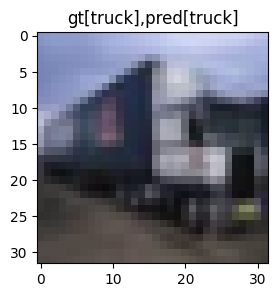

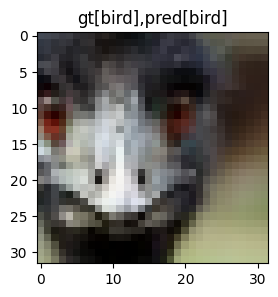

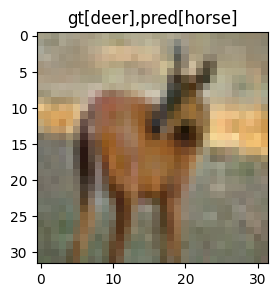

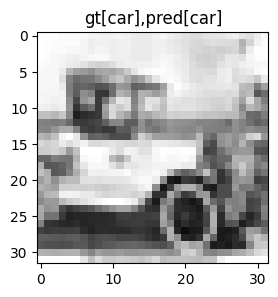

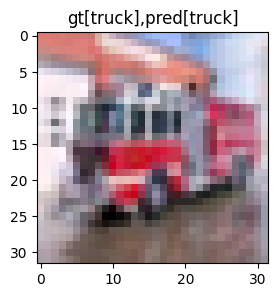

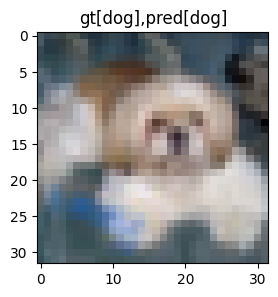

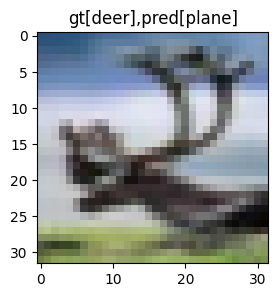

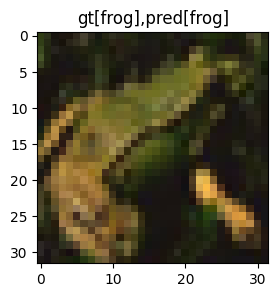

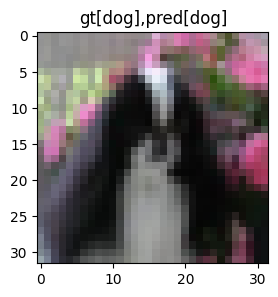

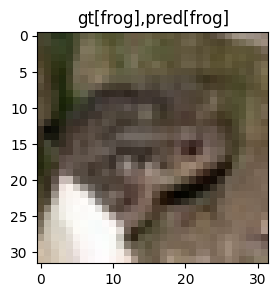

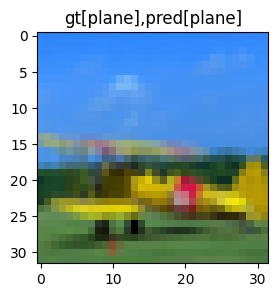

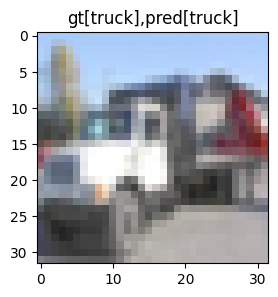

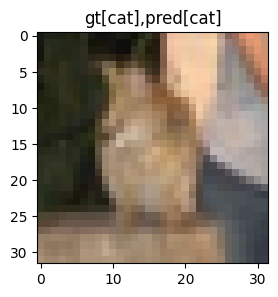

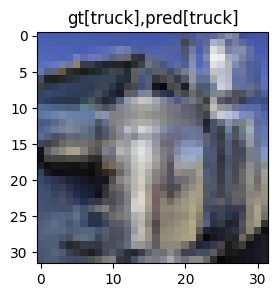

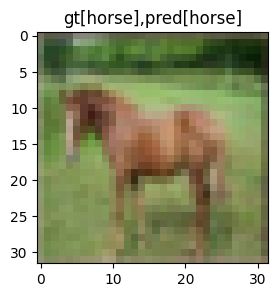

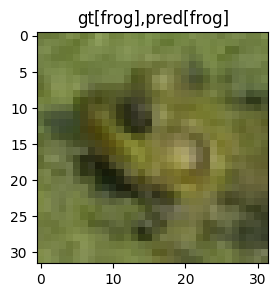

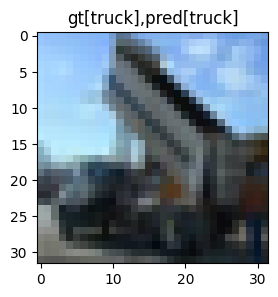

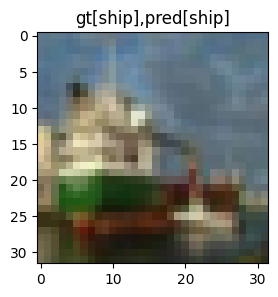

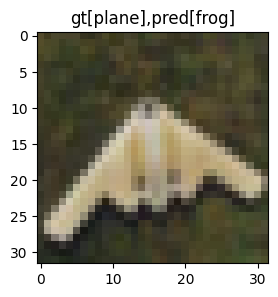

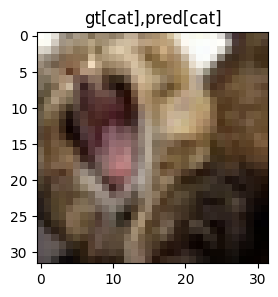

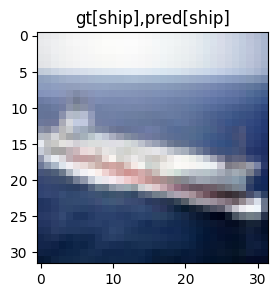

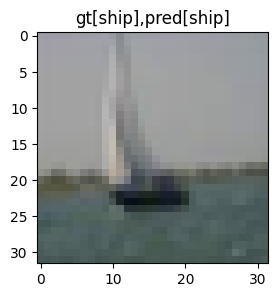

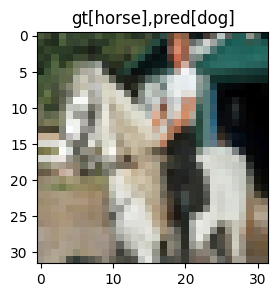

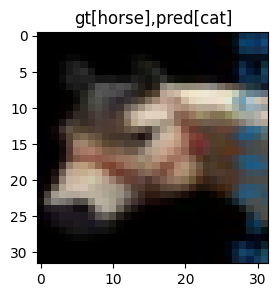

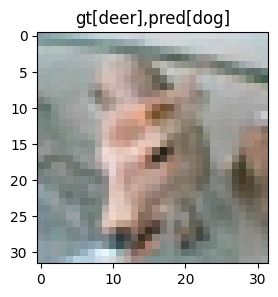

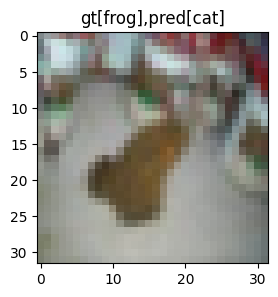

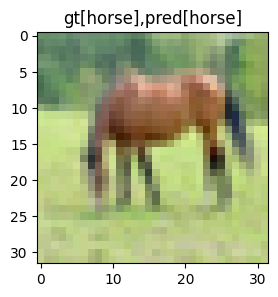

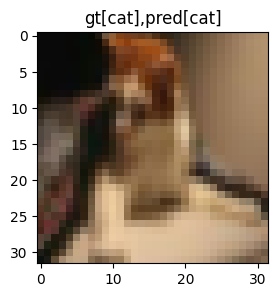

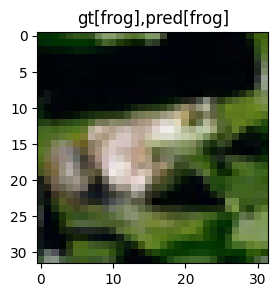

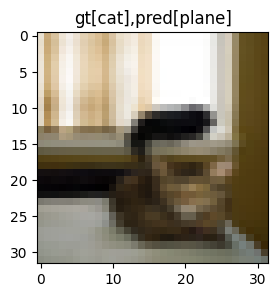

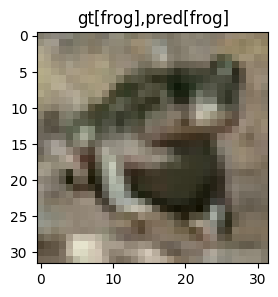

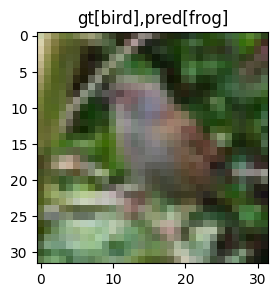

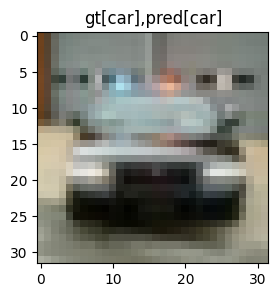

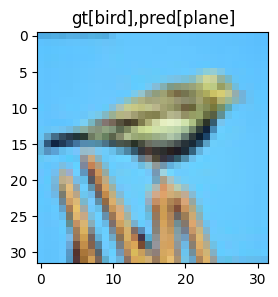

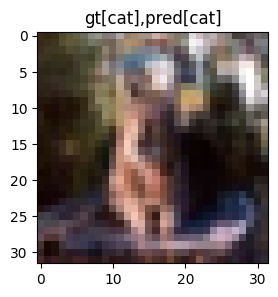

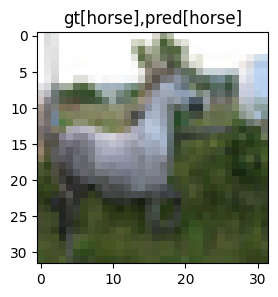

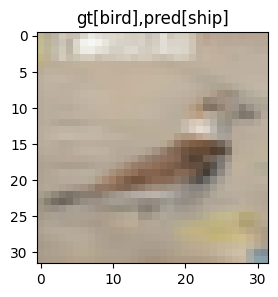

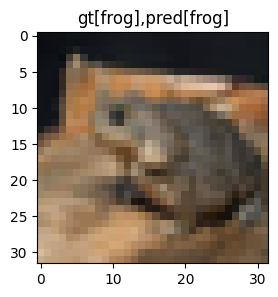

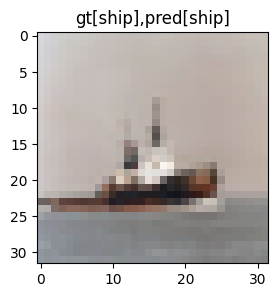

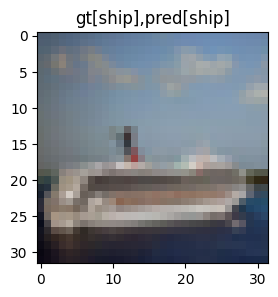

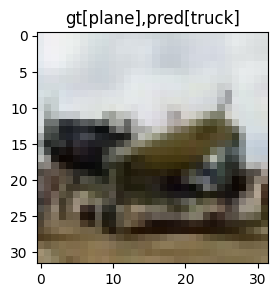

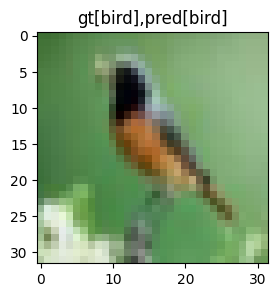

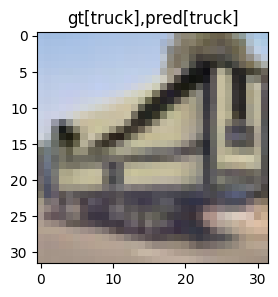

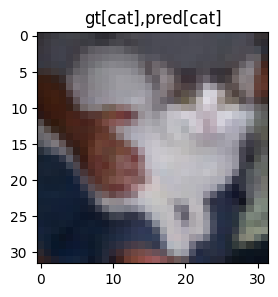

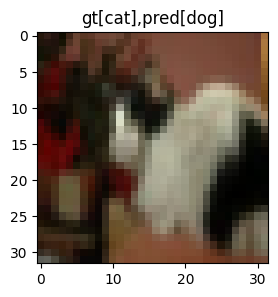

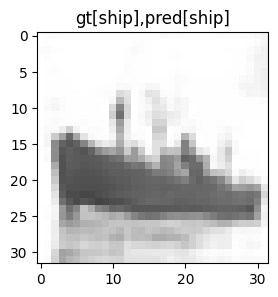

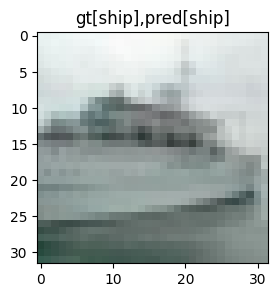

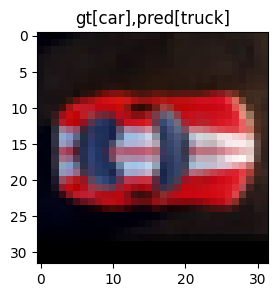

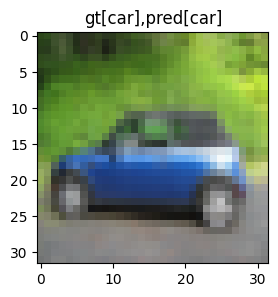

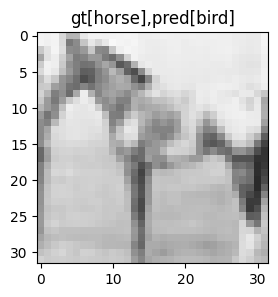

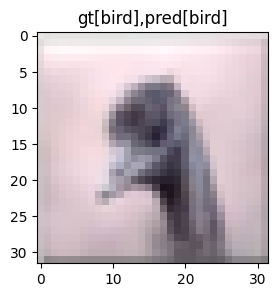

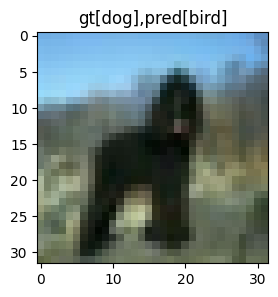

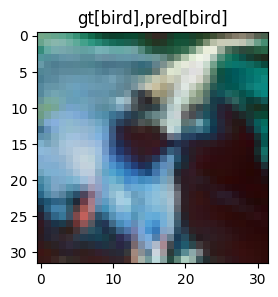

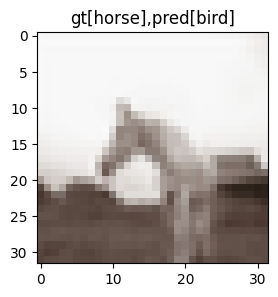

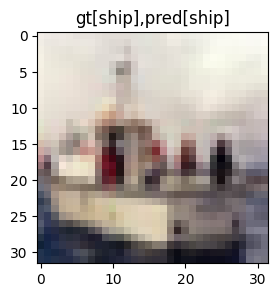

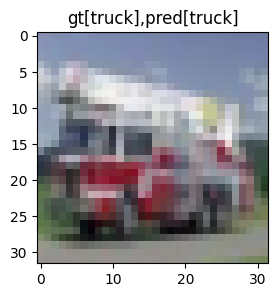

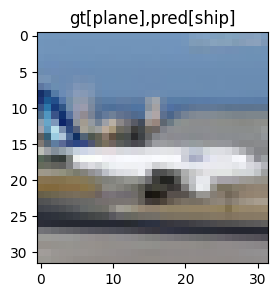

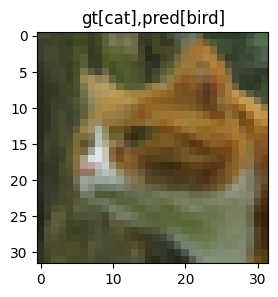

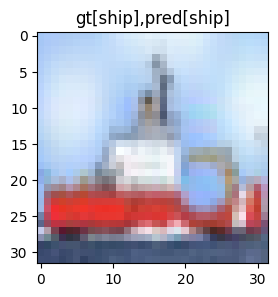

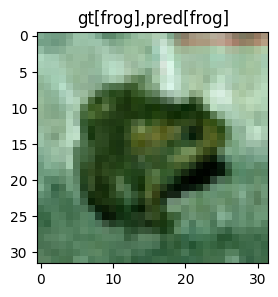

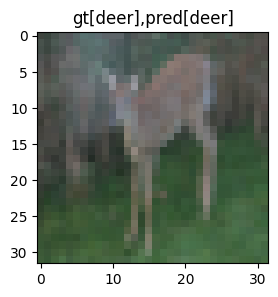

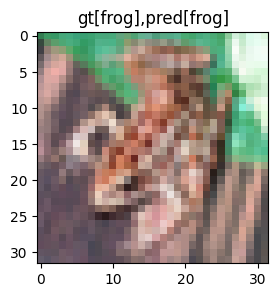

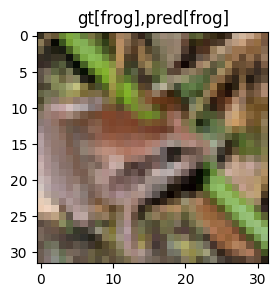

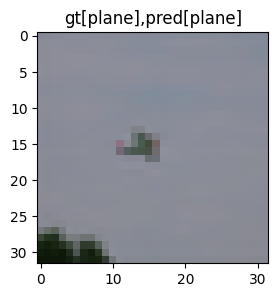

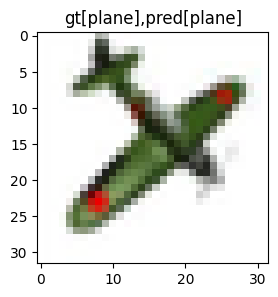

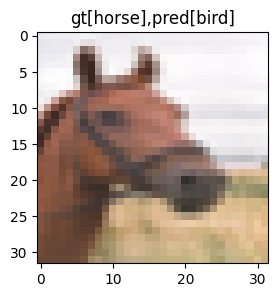

In [69]:
for it_sample in range(sample[0].shape[0]):
  display_sample(sample[0][it_sample], sample[1][it_sample], pred[it_sample])